# **CODE**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import numpy as np

## HYPERPARAMETERS

In [ ]:
num_epochs = 100
batch_size = 64

## DATASET LOADER

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, X, y, t):
    self.n_samples = X.shape[0]
    self.x_data = X
    self.y_data = y
    self.transform = t

  def __getitem__(self, index):
    if self.transform:
      return self.transform(self.x_data[index]), self.y_data[index]
    else:
      return self.x_data[index], self.y_data[index]

  def __len__(self):
    return self.n_samples

## IMPORTING DATA AND PREPROCESSING

In [ ]:
import pickle
from sklearn.model_selection import train_test_split

data = pickle.load(open("/content/drive/MyDrive/DL_A3/train.pkl","rb"))
X = data['images']
y = data['labels']

In [ ]:
X_ = []
for i in range(len(X)):
  X_.append(np.array(X[i]))
X = np.stack(X_)
print(X.shape) 

(5000, 32, 32, 3)


In [ ]:
y = np.array(y)
print(y.shape)

(5000,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

In [ ]:
train_transform = T.Compose([
  T.ToPILImage(),
  T.RandomHorizontalFlip(),
  T.RandomCrop(32, padding = 4),
  T.ToTensor(),
])

test_transform = T.Compose([
  T.ToPILImage(),
  T.ToTensor(),
])

In [ ]:
train_dataset = CustomDataset(X_train, y_train, train_transform)
test_dataset = CustomDataset(X_test, y_test, test_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [ ]:
# x = train_dataset[0][0].reshape(1,3,32,32).cuda()
# x = model.block1(x)
# x = model.block2(x)
# # x = model.block3(x)
# x.shape

## NEURAL NETWORK

In [ ]:
class CNN(nn.Module):
  
  def __init__(self):
    super(CNN, self).__init__()
    self.block1 = nn.Sequential(
        
        # X1
        nn.Conv2d(3, 16, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
        nn.BatchNorm2d(16),
        nn.ReLU(inplace=True),
        # X2
        nn.Conv2d(16, 16, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
        nn.BatchNorm2d(16),
        nn.ReLU(inplace=True),

        nn.MaxPool2d((2,2)),
    )

    self.block2 = nn.Sequential(
        
        # Y1
        nn.Conv2d(16, 32, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        # Y2
        nn.Conv2d(32, 32, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),

        nn.MaxPool2d((2,2)),
    )

    self.block3 = nn.Sequential(
        
        # Z1
        nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        # Z2
        nn.Conv2d(64, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),

        nn.MaxPool2d((2,2)),
    )
    
    self.classifier = nn.Sequential(
        nn.Linear(64*4*4, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),

        nn.Linear(512, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),

        nn.Linear(128, 10),
    )
  
  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = x.view(x.size()[0], -1)
    x = self.classifier(x)
    return x

### FUNCTION FOR MODEL EVALUATION

In [ ]:
def evaluate_model(model, data_loader, criterion):
    
    model.eval()
    
    n_correct = 0
    n_samples = 0

    net_loss = 0
    
    with torch.no_grad():
        for features, labels in data_loader:
            features = features.to(device)
            labels = labels.to(device)
            
            predictions = model(features)
            
            _, predicted = torch.max(predictions.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            loss = criterion(predictions, labels)
            net_loss += loss.item()

    acc = 100.0 * n_correct / n_samples
    net_loss /= len(data_loader)

    return acc, net_loss

## TRAINING THE MODEL

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.00001)

In [ ]:
model

CNN(
  (block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_

In [ ]:
n_total_steps = len(train_loader)

loss_best_model = 100
PATH = "/content/drive/MyDrive/DL_A3/A3_P1_Models/random_model.pt"

for epoch in range(num_epochs):
    for features, labels in train_loader:
        
        features = features.to(device)
        labels = labels.to(device)
        
        # Forward pass
        predictions = model(features)
        loss = criterion(predictions, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        model.eval()
        val_acc, val_loss = evaluate_model(model, test_loader, criterion)
        train_acc, train_loss = evaluate_model(model, train_loader, criterion)
        
        updated = ""

        if val_loss < loss_best_model:
            loss_best_model = val_loss
            updated = "++"
            torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'train_loss': train_loss,
              'val_loss': val_loss,
              'train_acc': train_acc,
              'val_acc': val_acc,
            }, PATH)

        print (f'Epoch [{epoch+1}/{num_epochs}], Train-Loss: {train_loss:.4f}, Val-Loss: {val_loss:.4f}, Train-Acc: {train_acc:.2f} %, Val-Acc: {val_acc:.2f} % {updated}')
        model.train()

Epoch [1/100], Train-Loss: 1.5240, Val-Loss: 1.5303, Train-Acc: 46.05 %, Val-Acc: 46.13 % ++
Epoch [2/100], Train-Loss: 1.2376, Val-Loss: 1.2262, Train-Acc: 56.64 %, Val-Acc: 57.20 % ++
Epoch [3/100], Train-Loss: 1.2629, Val-Loss: 1.2832, Train-Acc: 55.65 %, Val-Acc: 54.80 % 
Epoch [4/100], Train-Loss: 1.0757, Val-Loss: 1.1482, Train-Acc: 61.86 %, Val-Acc: 59.47 % ++
Epoch [5/100], Train-Loss: 0.9513, Val-Loss: 1.0021, Train-Acc: 65.86 %, Val-Acc: 62.67 % ++
Epoch [6/100], Train-Loss: 0.8476, Val-Loss: 0.9117, Train-Acc: 70.28 %, Val-Acc: 67.20 % ++
Epoch [7/100], Train-Loss: 1.0624, Val-Loss: 1.1554, Train-Acc: 63.46 %, Val-Acc: 61.07 % 
Epoch [8/100], Train-Loss: 0.7515, Val-Loss: 0.8203, Train-Acc: 74.14 %, Val-Acc: 71.47 % ++
Epoch [9/100], Train-Loss: 0.7563, Val-Loss: 0.8690, Train-Acc: 73.46 %, Val-Acc: 68.40 % 
Epoch [10/100], Train-Loss: 0.6354, Val-Loss: 0.6946, Train-Acc: 77.98 %, Val-Acc: 76.27 % ++
Epoch [11/100], Train-Loss: 0.9438, Val-Loss: 0.9838, Train-Acc: 67.67 %, V

# **DELIVERABLES**

## 1. Visualize 10 random images from each class.

In [ ]:
from matplotlib import pyplot as plt
np.unique(y)  # Classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
def random_samples(c, count=10):
  print(f"Class {c}:")

  fig = plt.figure(figsize = (20, 10))

  for j in range(10):
      image = X[y==c][j]
      ax = fig.add_subplot(1, 16+1, j+1)
      ax.imshow(image, cmap = 'bone')
      ax.set_title(f'Sample {j+1}')
      ax.axis('off')

Class 0:


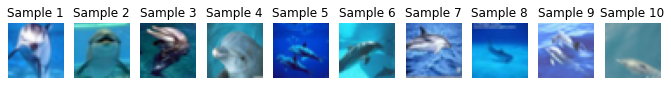

In [ ]:
random_samples(c=0) # Dolphin

Class 1:


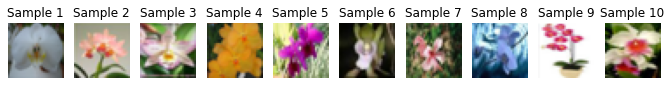

In [ ]:
random_samples(c=1) # Flower

Class 2:


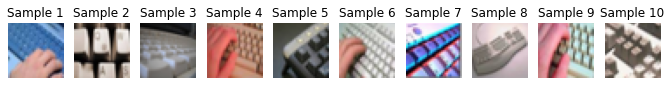

In [ ]:
random_samples(c=2) # Keyboard

Class 3:


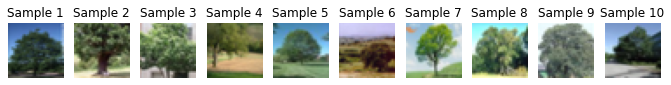

In [ ]:
random_samples(c=3) # Tree

Class 4:


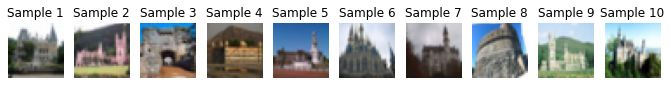

In [ ]:
random_samples(c=4) # Building

Class 5:


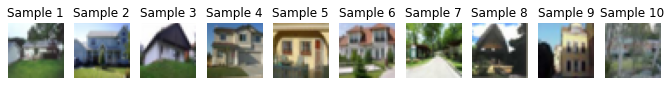

In [ ]:
random_samples(c=5) # House

Class 6:


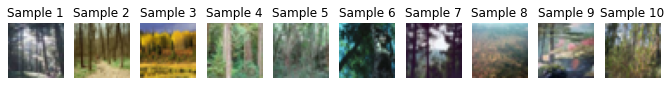

In [ ]:
random_samples(c=6) # Forest

Class 7:


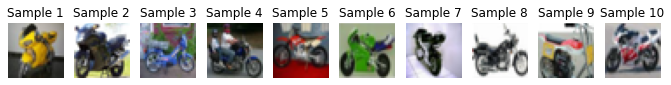

In [ ]:
random_samples(c=7) # Bike

Class 8:


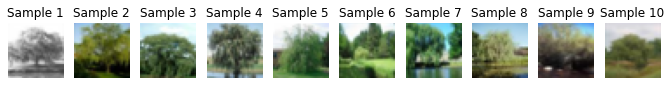

In [ ]:
random_samples(c=8) # Tree

Class 9:


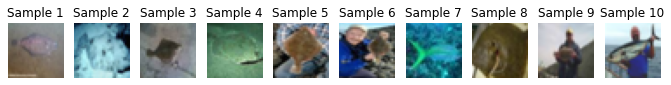

In [ ]:
random_samples(c=9) # Fishing

## 2. Analyze the accuracy and loss while adding block 1, block 2 and block 3

In [ ]:
PATH = "/content/drive/MyDrive/DL_A3/A3_P1_Models/block_1_only.pt"

checkpoint = torch.load(PATH)

model = CNN().cuda()
model.load_state_dict(checkpoint['model_state_dict'])

epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']
train_acc = checkpoint['train_acc']
val_acc = checkpoint['val_acc']
print (f'Epochs={epoch+1}, Train-Loss: {train_loss:.4f}, Val-Loss: {val_loss:.4f}, Train-Acc: {train_acc:.2f} %, Val-Acc: {val_acc:.2f} %')

Epochs=84, Train-Loss: 0.3532, Val-Loss: 0.5595, Train-Acc: 87.44 %, Val-Acc: 81.07 %


In [ ]:
PATH = "/content/drive/MyDrive/DL_A3/A3_P1_Models/block_1_and_2.pt"

checkpoint = torch.load(PATH)

model = CNN().cuda()
model.load_state_dict(checkpoint['model_state_dict'])

epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']
train_acc = checkpoint['train_acc']
val_acc = checkpoint['val_acc']
print (f'Epochs={epoch+1}, Train-Loss: {train_loss:.4f}, Val-Loss: {val_loss:.4f}, Train-Acc: {train_acc:.2f} %, Val-Acc: {val_acc:.2f} %')

Epochs=76, Train-Loss: 0.2198, Val-Loss: 0.5322, Train-Acc: 92.49 %, Val-Acc: 82.00 %


In [ ]:
PATH = "/content/drive/MyDrive/DL_A3/A3_P1_Models/block_1_2_and_3.pt"

checkpoint = torch.load(PATH)

model = CNN().cuda()
model.load_state_dict(checkpoint['model_state_dict'])

epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']
train_acc = checkpoint['train_acc']
val_acc = checkpoint['val_acc']
print (f'Epochs={epoch+1}, Train-Loss: {train_loss:.4f}, Val-Loss: {val_loss:.4f}, Train-Acc: {train_acc:.2f} %, Val-Acc: {val_acc:.2f} %')

Epochs=60, Train-Loss: 0.2010, Val-Loss: 0.5346, Train-Acc: 92.89 %, Val-Acc: 83.07 %


## 3. Analyze the accuracy and loss while changing the dropout probability. 
#### (Report the results obtained on CNN with all three blocks.)

In [ ]:
PATH = "/content/drive/MyDrive/DL_A3/A3_P1_Models/dropout_0_15.pt"

checkpoint = torch.load(PATH)

model = CNN().cuda()
model.load_state_dict(checkpoint['model_state_dict'])

epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']
train_acc = checkpoint['train_acc']
val_acc = checkpoint['val_acc']
print (f'Epochs={epoch+1}, Train-Loss: {train_loss:.4f}, Val-Loss: {val_loss:.4f}, Train-Acc: {train_acc:.2f} %, Val-Acc: {val_acc:.2f} %')

Epochs=42, Train-Loss: 0.1866, Val-Loss: 0.5679, Train-Acc: 93.11 %, Val-Acc: 81.20 %


In [ ]:
PATH = "/content/drive/MyDrive/DL_A3/A3_P1_Models/dropout_0_25.pt"

checkpoint = torch.load(PATH)

model = CNN().cuda()
model.load_state_dict(checkpoint['model_state_dict'])

epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']
train_acc = checkpoint['train_acc']
val_acc = checkpoint['val_acc']
print (f'Epochs={epoch+1}, Train-Loss: {train_loss:.4f}, Val-Loss: {val_loss:.4f}, Train-Acc: {train_acc:.2f} %, Val-Acc: {val_acc:.2f} %')

Epochs=53, Train-Loss: 0.1560, Val-Loss: 0.5363, Train-Acc: 94.59 %, Val-Acc: 82.40 %


In [ ]:
PATH = "/content/drive/MyDrive/DL_A3/A3_P1_Models/dropout_0_50.pt"

checkpoint = torch.load(PATH)

model = CNN().cuda()
model.load_state_dict(checkpoint['model_state_dict'])

epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']
train_acc = checkpoint['train_acc']
val_acc = checkpoint['val_acc']
print (f'Epochs={epoch+1}, Train-Loss: {train_loss:.4f}, Val-Loss: {val_loss:.4f}, Train-Acc: {train_acc:.2f} %, Val-Acc: {val_acc:.2f} %')

Epochs=57, Train-Loss: 0.2125, Val-Loss: 0.4951, Train-Acc: 92.59 %, Val-Acc: 84.13 %


## 4. Report the best accuracy with model architecture

In [ ]:
PATH = "/content/drive/MyDrive/DL_A3/A3_P1_Models/best_model.pt"

checkpoint = torch.load(PATH)

model = CNN().cuda()
model.load_state_dict(checkpoint['model_state_dict'])

epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']
train_acc = checkpoint['train_acc']
val_acc = checkpoint['val_acc']
print (f'Epochs={epoch+1}, Train-Loss: {train_loss:.4f}, Val-Loss: {val_loss:.4f}, Train-Acc: {train_acc:.2f} %, Val-Acc: {val_acc:.2f} %')

Epochs=57, Train-Loss: 0.2125, Val-Loss: 0.4951, Train-Acc: 92.59 %, Val-Acc: 84.13 %


In [ ]:
print(model)

CNN(
  (block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_

## 5. Visualize some convolutional filters and feature maps obtained after each block.

In [ ]:
from random import randint
from matplotlib import pyplot as plt

In [ ]:
def plot_feature_maps(features, offset=0):

  n_filters = features.shape[1]

  fig = plt.figure(figsize = (32, 10))

  for j in range(n_filters):
      image = features[0][j]
      ax = fig.add_subplot(1, n_filters+1, j+1)

      ax.imshow(image, cmap = 'bone')
      ax.set_title(f'Filter {j+1+offset}')
      ax.axis('off')

Input Image
Class: 5


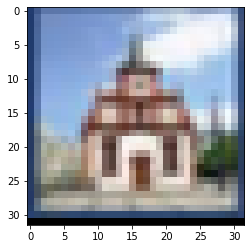

In [ ]:
ran = randint(0,X_train.shape[0])

img = train_dataset[ran][0].cpu().detach().numpy()
print("Input Image")
plt.imshow(img.transpose(1,2,0))
print("Class:",y_train[ran])

x = train_dataset[ran][0].reshape(1,3,32,32).to(device)

### Feature Maps

torch.Size([1, 16, 16, 16])


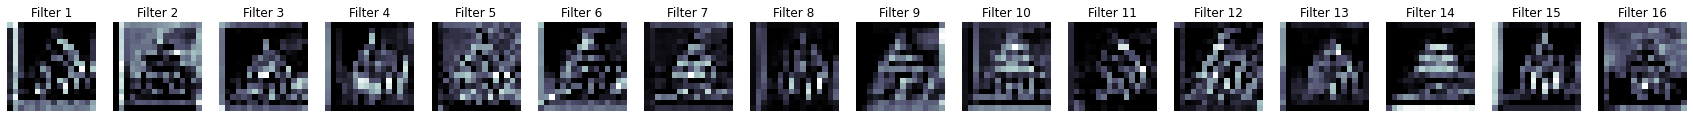

In [ ]:
x = model.block1(x)
print(x.shape)
plot_feature_maps(x.cpu().detach().numpy())

torch.Size([1, 32, 8, 8])


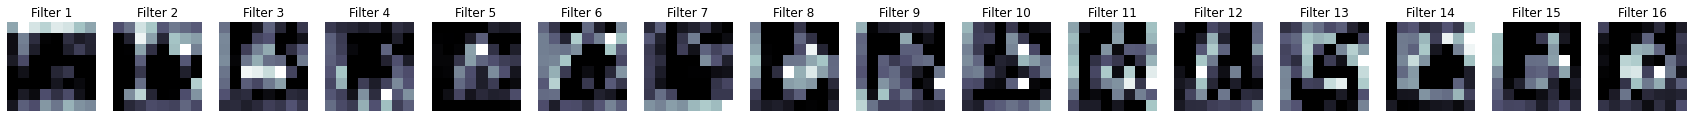

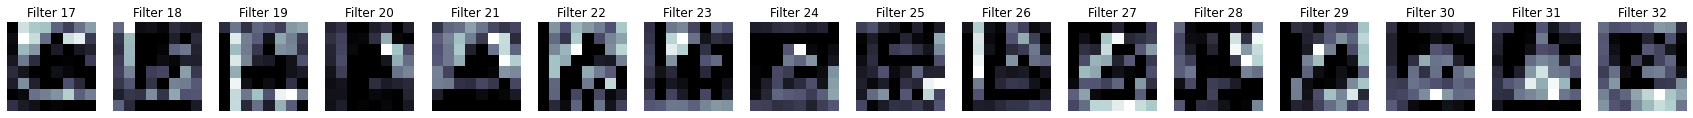

In [ ]:
x = model.block2(x)
print(x.shape)
x_ = x.cpu().detach().numpy()
plot_feature_maps(x_[:,:16,:,:])
plot_feature_maps(x_[:,16:,:,:], offset = 16)

torch.Size([1, 64, 4, 4])


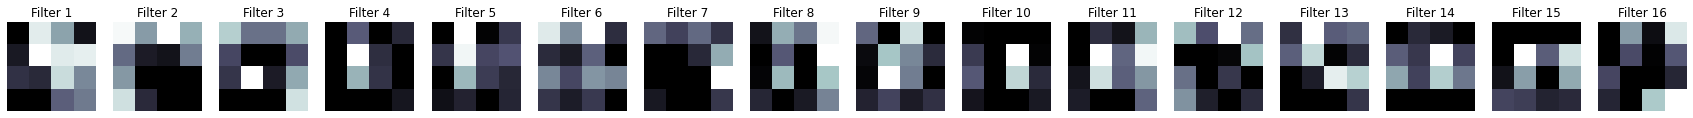

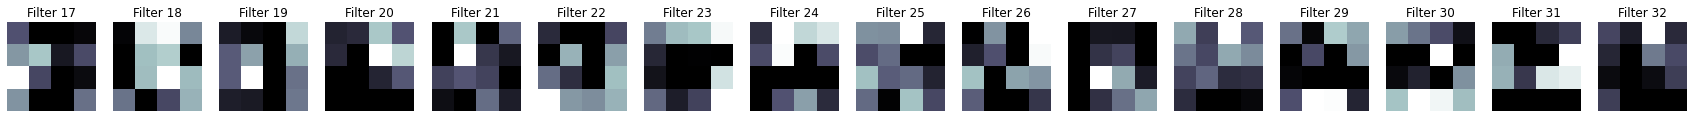

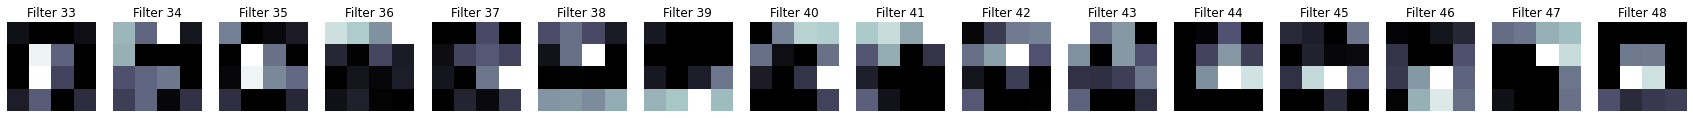

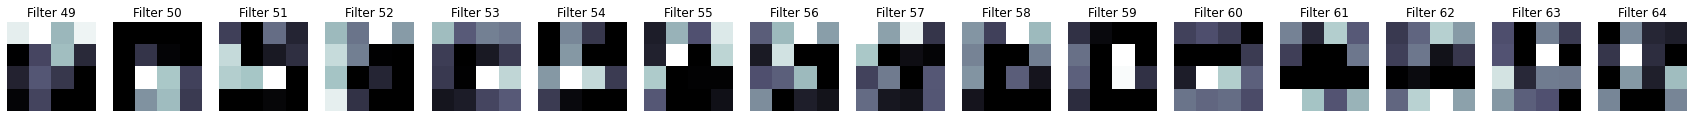

In [ ]:
x = model.block3(x)
print(x.shape)
x_ = x.cpu().detach().numpy()
plot_feature_maps(x_[:,:16,:,:])
plot_feature_maps(x_[:,16:32,:,:], offset = 16)
plot_feature_maps(x_[:,32:48,:,:], offset = 32)
plot_feature_maps(x_[:,48:,:,:], offset = 48)

### Convolution Filters
###### (Plotting only for the first input channel)

##### convX1

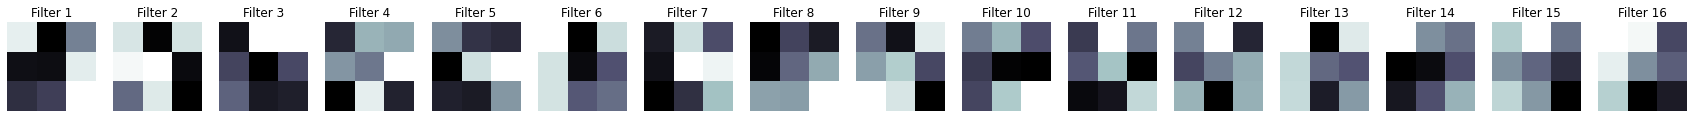

In [ ]:
filters = [param for param in model.block1[0].parameters()][0]
plot_feature_maps(filters.cpu().detach().numpy().transpose(1,0,2,3))

##### convX2

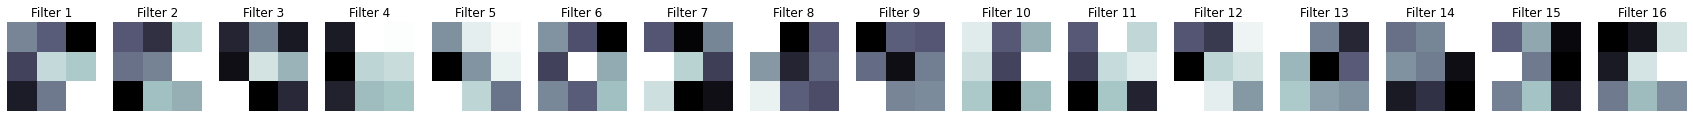

In [ ]:
filters = [param for param in model.block1[3].parameters()][0]
plot_feature_maps(filters.cpu().detach().numpy().transpose(1,0,2,3))

##### convY1

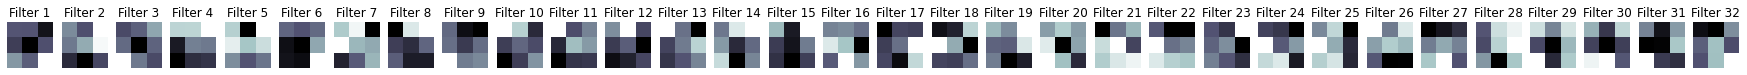

In [ ]:
filters = [param for param in model.block2[0].parameters()][0]
plot_feature_maps(filters.cpu().detach().numpy().transpose(1,0,2,3))

##### convY2

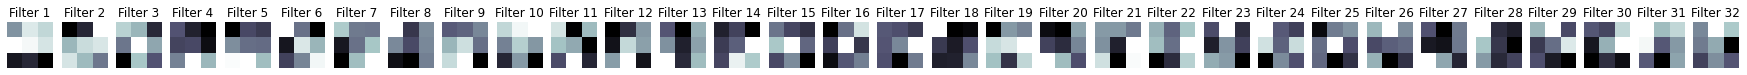

In [ ]:
filters = [param for param in model.block2[3].parameters()][0]
plot_feature_maps(filters.cpu().detach().numpy().transpose(1,0,2,3))

##### convZ1

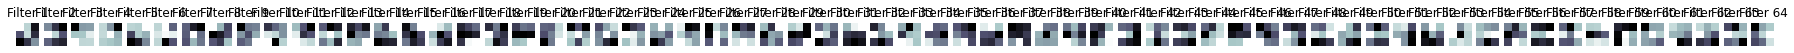

In [ ]:
filters = [param for param in model.block3[0].parameters()][0]
plot_feature_maps(filters.cpu().detach().numpy().transpose(1,0,2,3))

##### convZ2

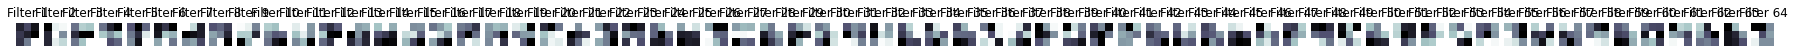

In [ ]:
filters = [param for param in model.block3[3].parameters()][0]
plot_feature_maps(filters.cpu().detach().numpy().transpose(1,0,2,3))

## 6. Analyze the results of the best model when all the activation functions are removed. Justify the performance drop.

In [ ]:
PATH = "/content/drive/MyDrive/DL_A3/A3_P1_Models/best_model_no_acti.pt"

checkpoint = torch.load(PATH)

model = CNN().cuda()
model.load_state_dict(checkpoint['model_state_dict'])

epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']
train_acc = checkpoint['train_acc']
val_acc = checkpoint['val_acc']
print (f'Epochs={epoch+1}, Train-Loss: {train_loss:.4f}, Val-Loss: {val_loss:.4f}, Train-Acc: {train_acc:.2f} %, Val-Acc: {val_acc:.2f} %')

Epochs=53, Train-Loss: 0.4378, Val-Loss: 0.5902, Train-Acc: 84.85 %, Val-Acc: 80.53 %


## 7. [Bonus] During demo your are given labels of test data (format will be same as training data), you have to evaluate the test accuracy of your best model.

In [ ]:
import pickle

test_data = pickle.load(open("/content/drive/MyDrive/DL_A3/train.pkl","rb"))
X = test_data['images']
y = test_data['labels']

In [ ]:
X_ = []
for i in range(len(X)):
  X_.append(np.array(X[i]))
X = np.stack(X_)
print(X.shape) 

(5000, 32, 32, 3)


In [ ]:
y = np.array(y)
print(y.shape)

(5000,)


In [ ]:
bonus_test_dataset = CustomDataset(X, y, test_transform)
bonus_test_loader = torch.utils.data.DataLoader(dataset=bonus_test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [ ]:
bonus_test_acc, bonus_test_loss = evaluate_model(model, bonus_test_loader, criterion)
print (f'Bonus-Test-Loss: {bonus_test_loss:.4f}, Bonus-Test-Acc: {bonus_test_acc:.2f} %')

Bonus-Test-Loss: 0.2101, Bonus-Test-Acc: 92.76 %
